# Flatiron Phase 2 Project
## Aaron Galbraith
### Submitted: March 6, 2023

# Business Understanding
The Hazel Paisley Appraisal Corporation currently performs home appraisals in the area of Olympia, Washington, and they wish to expand their operations into King County, which includes Seattle and many other adjacent municipalities. They are unfamiliar with the Seattle metro area and seek to learn what factors matter most in determining home values. As their appraisers become more familiar with the idiosyncracies of the housing market in King County they will add their own nuance to our formula. The purposes of this project will be to highlight the most important factors to include in a simple model that broadly approximates home values and indicates to the Hazel Paisley Appraisal Corporation what data they should focus on to better understand appraisal values in this region.

# Data Understanding
First we'll import the data and try to understand its features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

# import the data
df = pd.read_csv('data/kc_house_data.csv')

In [2]:
# show the shape of the data, rows and columns
df.shape

(30155, 25)

In [3]:
# show the column titles
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

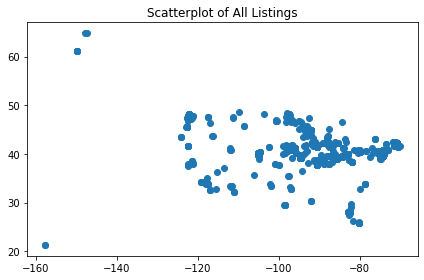

In [4]:
# plot all listings using their longitude and latitude coordinates
fig, ax = plt.subplots()
ax.scatter(df['long'],df['lat'])
plt.title('Scatterplot of All Listings')
fig.tight_layout();

In [5]:
# show the broad details of the price feature
df['price'].describe()

count    3.015500e+04
mean     1.108536e+06
std      8.963857e+05
min      2.736000e+04
25%      6.480000e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64

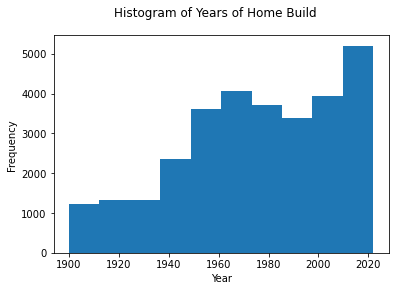

In [6]:
# show a histogram of when the homes were built
ax = df['yr_built'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Years of Home Build')
plt.xlabel('Year');

In [7]:
# show how many records are duplicated
len(df[df.duplicated()])

1

We'll drop the single duplicated record.

In [8]:
# drop the duplicates
df.drop_duplicates(inplace=True)

In [9]:
# iterate over all columns to find missing values
for col in df.columns:
    if df[col].isna().sum() > 0:
        # show which values are missing
        print(col, df[col].isna().sum()) 

heat_source 32
sewer_system 14


Later we'll create a feature that can compare values to neighbors. Perhaps we can infer these values from what seems to be popular with neighbors of these listings.

## Summary of Data Understanding
There appear to be listings from all over the United States, not just in King County in the state of Washington, as expected. The data is otherwise fairly clean, in that there are very few missing or duplicated records to worry about.

There are over 30,000 records and 25 columns. The columns are a mix of numerical continuous features, numerical discrete features, and categorical features. The columns for date and address can have other helpful features extracted from them.

# Data Preparation
## Adding and Adjusting Columns
### Creating and Extracting, Based on Existing Columns

There are a few relatively obvious features we can create that should help us understand this data set:
- price-per-square-foot (from price and sqft_living_area)
- city (from address)
- state (from address)
- zip (from address)

In [10]:
# create price per square foot feature by dividing price by living area
df['ppsqft'] = df['price'] / df['sqft_living']
# extract state from address
df['state'] = df['address'].apply(lambda x: str(x).split(' ')[-4])
# extract zip code from address
df['zip'] = df['address'].apply(lambda x: str(x).split(' ')[-3].replace(',', ''))
# extract city from address
df['city'] = df['address'].apply(lambda x: str(x).split(',')[-3].strip())

### Label Encoding
The "view", "condition", and "grade" fields should all be label-encoded.

In [11]:
# a function that label encodes the view feature
def view(x):
    if x == 'NONE':
        return 0
    elif x == 'FAIR':
        return 1
    elif x == 'AVERAGE':
        return 2
    elif x == 'GOOD':
        return 3
    elif x == 'EXCELLENT':
        return 4

# run the function to apply label encoding for the view feature
df['view'] = df['view'].apply(lambda x: view(x))

# a function that label encodes the condition feature
def condition(x):
    if x == 'Poor':
        return 0
    elif x == 'Fair':
        return 1
    elif x == 'Average':
        return 2
    elif x == 'Good':
        return 3
    elif x == 'Very Good':
        return 4

# run the function to apply label encoding for the condition feature
df['condition'] = df['condition'].apply(lambda x: condition(x))

# label encode the grade feature by applying a lambda function to extract the numerical values
df['grade'] = df['grade'].apply(lambda x: int(x[:2].strip()))

The "year renovated" has a zero value for most of the entries, which is not mathematically compatible. We'll create some more relevant fields: From the "date" feature we'll extract the "year of sale" and then the "age" of the house. Then for renovations we'll assume a new build is as good as a renovation, so "years since renovation" can just be the same as a house's age if it's never been renovated.

In [12]:
# create new feature extracting the year of sale from the date feature
df['year_of_sale'] = df['date'].apply(lambda x: int(x[-4:]))
# create new age feature by subtracting year of build from year of sale
df['age'] = df['year_of_sale'] - df['yr_built']
# create new feature for "years since renovation" that defaults to the age of the home if it was never renovated
df['years_since_renovation'] = df.apply(
    lambda x: x.age if x.yr_renovated == 0 else x.year_of_sale - x.yr_renovated, axis=1)

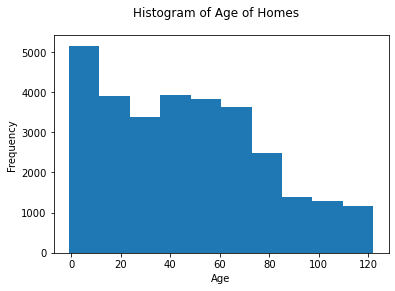

In [13]:
# show the age of the homes in a histogram
ax = df['age'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Age of Homes')
plt.xlabel('Age');

In [14]:
# show how many homes have been renovated
len(df[df['yr_renovated'] > 0])

1372

1,372 of the homes have been renovated, which is roughly 1 of every 25.

Of the renovated homes, let's look at *when* they were renovated.

## Exploring the Data Via Lat/Long Maps and Removing Out-of-Range Records

Let's get an idea of where these listings are. We can do so by making a scatterplot of the longitude and latitude entries.

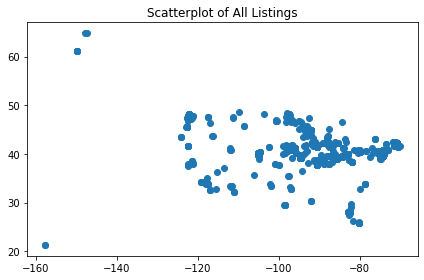

In [15]:
# plot all listings by longitude and latitude
fig, ax = plt.subplots()
ax.scatter(df['long'],df['lat'])

plt.title('Scatterplot of All Listings')
fig.tight_layout();

For some reason, this appears to include listings from nearly all 50 states, while were supposed to be focusing on just one county in Washington.

In [16]:
# print summary of listings
print('Total listings: ' + str(len(df)))
print('Out of state listings: ' + str(len(df[df['state'] != 'Washington'])))

Total listings: 30154
Out of state listings: 910


We'll get rid of out-of-state listings and look just at Washington.

In [17]:
# group the indices of 'bad' records in a set to be dropped
out_of_range = set(df[df['state'] != 'Washington'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

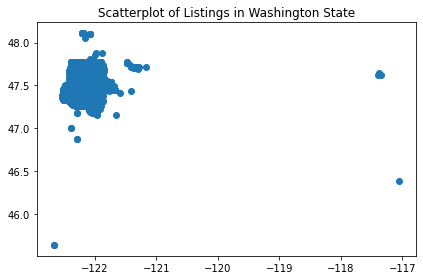

In [18]:
# show map of remaining listings
fig, ax = plt.subplots()
ax.scatter(df_map['long'],df_map['lat'])

plt.title('Scatterplot of Listings in Washington State')
fig.tight_layout();

In [19]:
# show list of cities in remaining listings
df['city'].value_counts()

Seattle          9372
Renton           1946
Kent             1583
Bellevue         1530
Auburn           1513
                 ... 
North Liberty       1
Pittsburgh          1
Pine City           1
El Cerrito          1
Oakland             1
Name: city, Length: 315, dtype: int64

There are still some far-flung properties in places like Spokane. We could just include/exclude based on the "city" field, but there are 315 unique cities, too many to sort in any simple way.

We can look up cities using long/lat approaching from all directions and eliminate anything that isn't in King County. (We can just look up what county the city belongs to on Wikipedia.)

In [20]:
# look at most extreme longitudes from the east
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=False)[:5]

,long
city,
Clarkston,-117.056550
Spokane,-117.375921
Skykomish,-121.332524
Snoqualmie Pass,-121.417590
Baring,-121.470469


In [21]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Clarkston'].index)
out_of_range.update(df[df['city'] == 'Spokane'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

In [22]:
# look at most extreme latitudes from the south
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=True)[:5]

,lat
city,
Vancouver,45.636805
Eatonville,46.876426
Spanaway,47.002985
Puyallup,47.178090
Enumclaw,47.212415


In [23]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Vancouver'].index)
out_of_range.update(df[df['city'] == 'Eatonville'].index)
out_of_range.update(df[df['city'] == 'Spanaway'].index)
out_of_range.update(df[df['city'] == 'Puyallup'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

This region features two cities, Milton and Auburn, that spill over into neighboring Pierce County to the south.

In [24]:
# observe listings that belong to Pierce County instead of King County
df_map[
       (df_map['lat'] < 47.257510) &
       (df_map['long'] < -122.144411)
      ][['address', 'price', 'sqft_living', 'sqft_lot', 'bedrooms']]

,address,price,sqft_living,sqft_lot,bedrooms
1236,"4018 South 384th Street, Auburn, Washington 98...",380000.0,1250,18700,3
24148,"1901 Alder Place, Milton, Washington 98354, Un...",610000.0,1610,9644,4
27679,"98 27th Avenue, Milton, Washington 98354, Unit...",550000.0,1840,9851,4


It appears that there are exactly three listings in this area that are not in King County. Let's look at where exactly they are on the map.

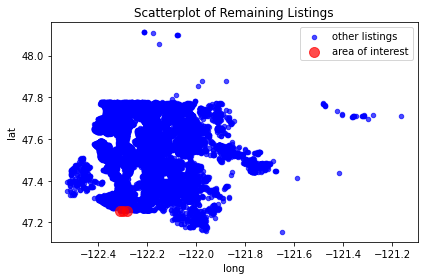

In [25]:
# create map of remaining listings, highlighting in red the listings of interest
# create a list of indices reflecting the listings of interest
highlight = df_map[
       (df_map['lat'] < 47.257510) &
       (df_map['long'] < -122.144411)
      ].index

# group the highlighted listings and the rest in separate lists
blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

# show the map
fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='other listings')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='area of interest')

ax.legend()

plt.title('Scatterplot of Remaining Listings')

fig.tight_layout();

These 3 listings are essentially contiguous with the rest of the records, but technically belong to another county. They don't otherwise appear anomalous, so we'll keep them.

In [26]:
# look at most extreme latitudes from the north
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=False)[:8]

,lat
city,
Tulalip,48.111504
Arlington,48.100735
Marysville,48.082740
Monroe,47.824948
Snohomish,47.811287
Baring,47.760969
Lake Forest Park,47.759078
Bothell,47.757407


In [27]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Tulalip'].index)
out_of_range.update(df[df['city'] == 'Arlington'].index)
out_of_range.update(df[df['city'] == 'Marysville'].index)
out_of_range.update(df[df['city'] == 'Monroe'].index)
out_of_range.update(df[df['city'] == 'Snohomish'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

In [28]:
# look at most extreme longitudes from the west
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=True)[:5]

,long
city,
Vashon,-122.467801
Dilworth,-122.439530
Dash Point,-122.416100
White Center,-122.363360
Normandy Park,-122.343426


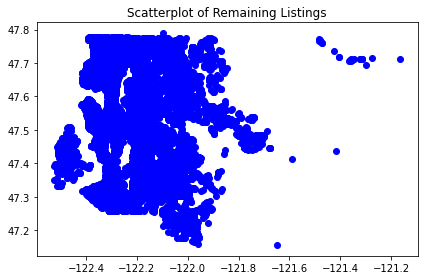

In [29]:
# show map of remaining listings
fig, ax = plt.subplots()
ax.scatter(df_map['long'],df_map['lat'], color="blue")

plt.title('Scatterplot of Remaining Listings')
fig.tight_layout();

We'll investigate the dot by itself that looks like it's just above the county line.

In [30]:
# show the three northernmost records
df_map.sort_values('lat', ascending=False)[:3][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
24605,47.78983,-122.097078,Woodinville,98077
25634,47.77764,-122.376830,Shoreline,98177
29110,47.77758,-122.352405,Shoreline,98133


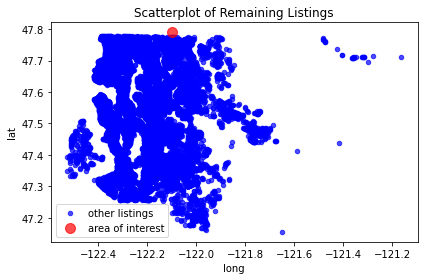

In [31]:
# show location of anomalous dot to confirm we're looking at the right listing
highlight = [24605]
blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]
fig, ax = plt.subplots()
blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='other listings')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='area of interest')
ax.legend()
plt.title('Scatterplot of Remaining Listings')
fig.tight_layout();

The single northernmost anomalous dot is at a latitude located neither in King County nor in Woodinville. It could be an error, but we wouldn't know how to correct it, so we'll drop it.

In [32]:
# update the set of indices of 'bad' records to be dropped
out_of_range.add(24605)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the strip of dots to the northeast along State Highway 2.

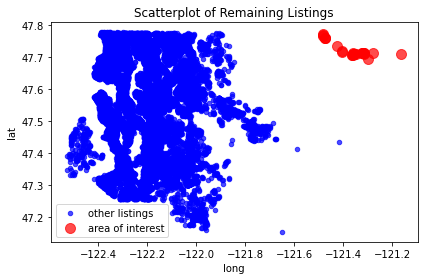

In [33]:
# create map of remaining listings, highlighting in red the listings of interest
# create a list of indices reflecting the listings of interest
highlight = df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='other listings')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='area of interest')

ax.legend()

plt.title('Scatterplot of Remaining Listings')

fig.tight_layout();

Let's figure out what cities these are.

In [34]:
# show listings to the north and east of certain lat/long values
df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['city'].value_counts()

Skykomish    19
Baring        7
Name: city, dtype: int64

We'll observe some basic attributes about these 26 listings.

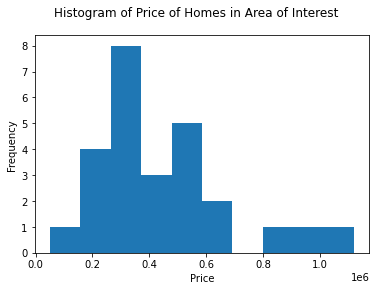

In [35]:
# show histogram of home prices for these 26 listings
ax = df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['price'].plot(
    kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Price of Homes in Area of Interest'
)

plt.xlabel('Price');

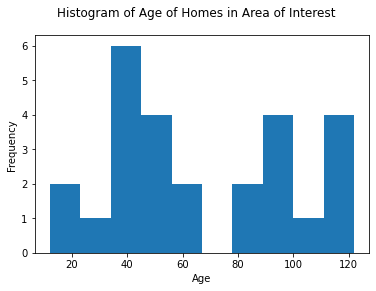

In [36]:
# show histogram for home ages for these 26 listings
ax = df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['age'].plot(
    kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Age of Homes in Area of Interest'
)

plt.xlabel('Age');

There are 26 listings along State Highway 2 that are pretty far out from the main urban area. This appears to be about an hour's drive in good traffic from the rest of the city. It doesn't seem relevant enough to the data set to keep, so we'll drop them.

In [37]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the stray dot to the south.

In [38]:
# show listing to the south and east of certain lat/long values
df_map[(df_map['lat'] < 47.2) & (df_map['long'] > -121.8)][['city', 'lat', 'long', 'address']]

,city,lat,long,address
2930,Enumclaw,47.155265,-121.648225,"52309 SE 496th Pl, Enumclaw, Washington 98022,..."


The anomalous listing has an address in the city of Enumclaw. This appears to be a remote community, far from the city its address claims (Enumclaw). It doesn't appear to be an error, but it still represents a community with no immediate neighbors for comparison. As such, we'll drop it.

In [39]:
# update the set of indices of 'bad' records to be dropped
out_of_range.add(2930)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the stray dots in the middle by pinching the latitude and searching longitude from east to west.

In [40]:
# show listings with specific long/lat values in an area in the middle of the map
df_map[(df_map['lat'] > 47.3)
       & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:8][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
17663,47.437030,-121.41759,Snoqualmie Pass,98045
20216,47.413610,-121.58837,North Bend,98045
14924,47.444770,-121.67469,North Bend,98045
11277,47.444905,-121.67554,North Bend,98045
28815,47.444655,-121.67839,North Bend,98045
28816,47.444745,-121.67879,North Bend,98045
8473,47.496180,-121.68674,North Bend,98045
15081,47.480100,-121.69844,North Bend,98045


Investigating these coordinates on Google Maps shows that he first three of these are something like the "Enumclaw" anomaly discussed earlier, but everything else appears to belong to a cluster worth keeping. We'll drop just those three.

In [41]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df_map[(df_map['lat'] > 47.3)
                           & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:3].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at two final listings that appear remotely located from the rest.

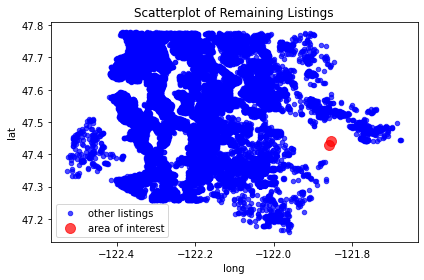

In [42]:
# isolate indices for listings in a remote location determined by their lat/long values
highlight = df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='other listings')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='area of interest')

ax.legend()

plt.title('Scatterplot of Remaining Listings')

fig.tight_layout();

In [43]:
# show information about these listings
df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ][['address', 'price', 'grade', 'condition', 'heat_source', 'sqft_living', 'sqft_lot', 'bathrooms']]

,address,price,grade,condition,heat_source,sqft_living,sqft_lot,bathrooms
20448,"19109 364th Avenue Southeast, Maple Valley, Wa...",885000.0,8,2,Gas,2240,305355,2.0
24342,"17800 364th Avenue Southeast, Maple Valley, Wa...",1115000.0,4,2,NaN,660,1210096,1.0


One of these is a "low grade" 1-bedroom that sold for $1.115 million, which raises enough questions. It would seem fair to drop both of them.

In [44]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update([20448, 24342])

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

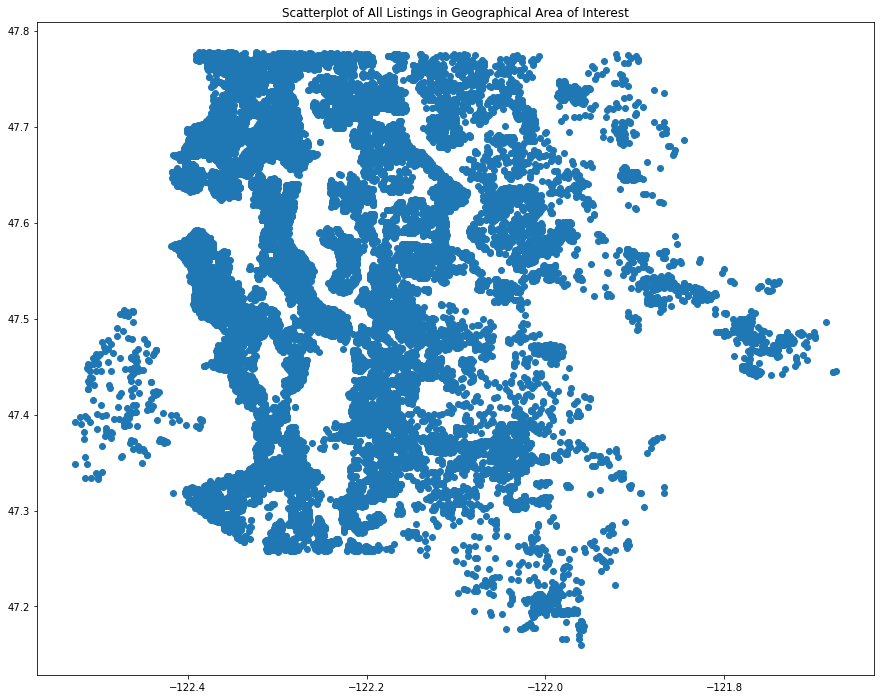

In [45]:
# display larger map of all remaining listings
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(df_map['long'],df_map['lat'])

plt.title('Scatterplot of All Listings in Geographical Area of Interest');

Geographically, at least, this looks like the data we want to work with. Let's explore what cities and zip codes this entails.

In [46]:
df_map['city'].describe()

count       29182
unique         51
top       Seattle
freq         9372
Name: city, dtype: object

In [47]:
df_map['zip'].describe()

count     29182
unique       76
top       98042
freq        992
Name: zip, dtype: object

In [48]:
print('We have dropped ' + str(len(df) - len(df_map)) + ' records, about '
      + str(round(100*(1 - len(df_map) / len(df)),2)) + '% of them.')

We have dropped 972 records, about 3.22% of them.


We'll lock in the changes to the main dataframe.

In [49]:
# update main dataframe with the version we have been editing
df = df_map.copy()

Now we'll build some functions that will give us a list of everyone's closest neighbors for the purpose of comparing values with listings nearby.

In [50]:
# compute the distance in feet between two coordinates
def distance(lat1, long1, lat2, long2):
    x = abs(lat2-lat1)*364732.89
    y = abs(long2-long1)*249526.96
    return np.sqrt(x**2 + y**2)

The "neighbors" function was developed over many drafts. The goal is to generate a list of neighbors for each listing. The criteria for inclusion are 1) proximity, as measured by the distance function, and 2) same or similar number of bedrooms. The idea is to find a list of properties worthy of comparison so that we can analyze what is essentially normal for homes of that size in that area and possibly identify anomalies indicitave of errors (and drop those records).

It isn't convenient or feasible to generate the same number of neighbors for every listing nor to limit each list of neighbors to the same radius for all listings. The best version of the function starts with a radius of 250 feet and either expands or contracts the radius until it generates a list of between 15 and 40 neighbors within that modified desired radius.

In [51]:
# this function will return a list of indices for listings that are near a certain listing and have the same or
# a similar number of bedrooms
def neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count):
    # generate an initial list according to number of bedrooms
    if brs == 0:
        neighbor_list = df[
            (df['bedrooms'] < 2) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 1:
        neighbor_list = df[
            (df['bedrooms'] < 3) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 2:
        neighbor_list = df[
            (df['bedrooms'] > 0) & (df['bedrooms'] < 4) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 3:
        neighbor_list = df[
            (df['bedrooms'] > 1) & (df['bedrooms'] < 5) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs < 6:
        neighbor_list = df[
            (df['bedrooms'] > 2) & (df['bedrooms'] < 7) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs > 5:
        neighbor_list = df[
            (df['bedrooms'] > 4) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    
    # expand the radius and rerun if the list of neighbors is too small
    if len(neighbor_list) < min_neighbor_count:
        too_small_factor = min_neighbor_count / len(neighbor_list)
        radius *= 3.5
        return neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count)
    # contract the radius and rerun if the list of neighbors is too long
    elif len(neighbor_list) > max_neighbor_count:
        too_big_factor = max_neighbor_count / len(neighbor_list)
        radius *= 0.75
        return neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count)
    # accept the list otherwise
    else:
        return neighbor_list

This "nearby" function helps generate new columns that show the median of a certain column value, e.g. living area, for all of a listing's neighbors (from its neighbor list).

In [52]:
def nearby(neighbor_list, column):
    return df.loc[neighbor_list][column].median()

The cells below create the neighbor lists and generates the 'nearby' features — the median value of a neighbor list for a given feature

**WARNING — the next several cells take several minutes to run**

In [53]:
# create the neighbor list feature
df['neighbor_list'] = df.apply(lambda x: neighbors(x.bedrooms, x.lat, x.long, 250, 15, 40), axis=1)

In [54]:
# show the breakdown of neighbor list length
df['neighbor_counts'] = df['neighbor_list'].apply(lambda x: len(x))
df['neighbor_counts'].value_counts()

33    1447
34    1401
32    1391
30    1360
28    1356
31    1346
29    1334
27    1307
35    1306
26    1293
37    1247
36    1245
38    1160
25    1146
24    1127
39    1100
40    1084
22     973
15     938
23     919
16     862
21     842
20     767
18     765
17     746
19     720
Name: neighbor_counts, dtype: int64

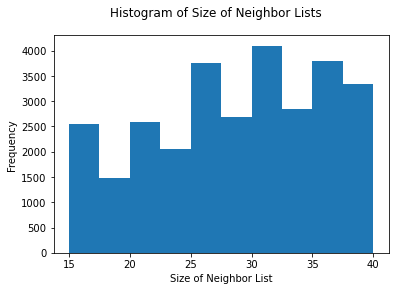

In [55]:
# show a histogram of neighbor list length
ax = df['neighbor_counts'].plot(
    kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Size of Neighbor Lists')
plt.xlabel('Size of Neighbor List');

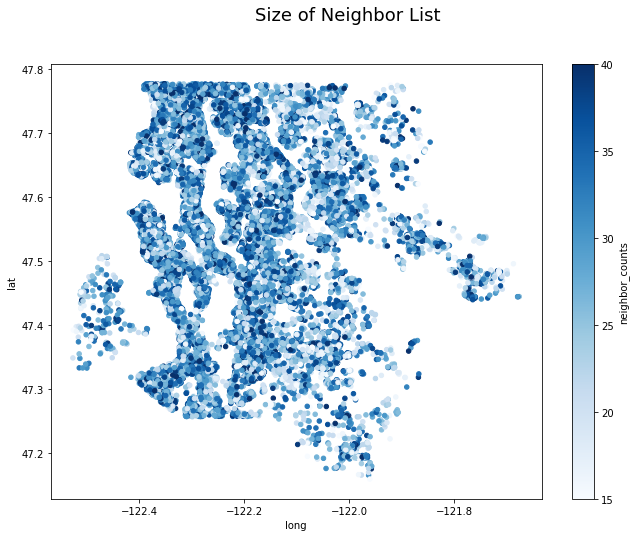

In [56]:
# show a map of all listings and neighbor list length
fig, ax = plt.subplots(figsize=(11,8))

df.plot.scatter(x='long', y='lat', c='neighbor_counts', cmap='Blues', ax=ax)
fig.suptitle('Size of Neighbor List', size=18);

Now all listings have their own "neighbor list" that includes between 15 and 40 closest neighbors. Neighbor list size seems to be distributed mostly evenly throughout the region.

Next we'll use this neighbor list to create new "nearby" features for every listing.

In [57]:
# create nearby median price
df['nearby_price'] = df.apply(lambda x: nearby(x.neighbor_list, 'price'), axis=1)

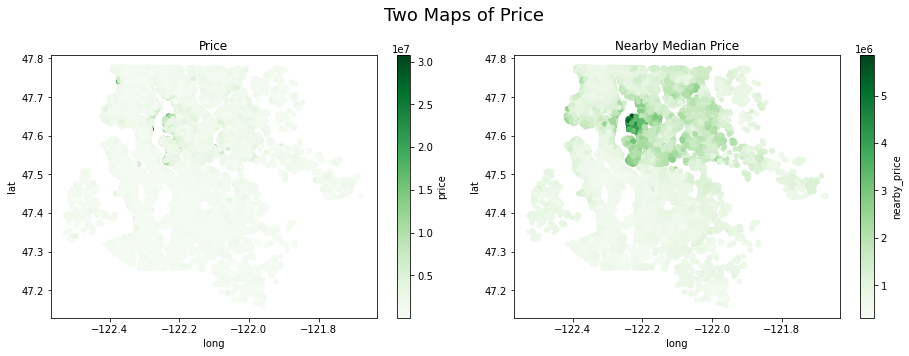

In [58]:
# display price (left) and nearby median price (right)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='price', cmap='Greens', ax=ax1, title='Price')
df.plot.scatter(x='long', y='lat', c='nearby_price', cmap='Greens', ax=ax2, title='Nearby Median Price')
fig.suptitle('Two Maps of Price', size=18)
fig.tight_layout();

Because home price is skewed, it doesn't map well on its own (unless possibly if we were to use a logarithmic scale). On the right, we see a "nearby price" map that shows a little more texture throughout the area and tells a more nuanced story of where nearby prices tend to be higher or lower.

In [59]:
# create nearby median living area feature
df['nearby_sqft_living'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_living'), axis=1)

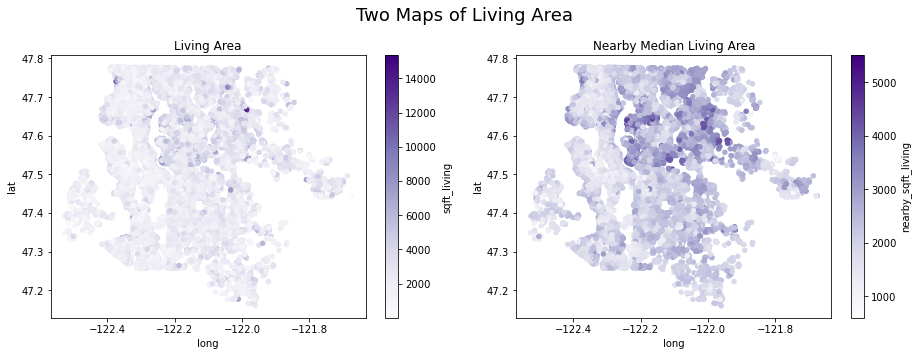

In [60]:
# display living area (left) and nearby median living area (right)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='sqft_living', cmap='Purples', ax=ax1, title='Living Area')
df.plot.scatter(x='long', y='lat', c='nearby_sqft_living', cmap='Purples', ax=ax2, title='Nearby Median Living Area')
fig.suptitle('Two Maps of Living Area', size=18)
fig.tight_layout();

Again, the "nearby" map shows a more nuanced picture for living area.

In [61]:
# create nearby lot area feature
df['nearby_sqft_lot'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_lot'), axis=1)

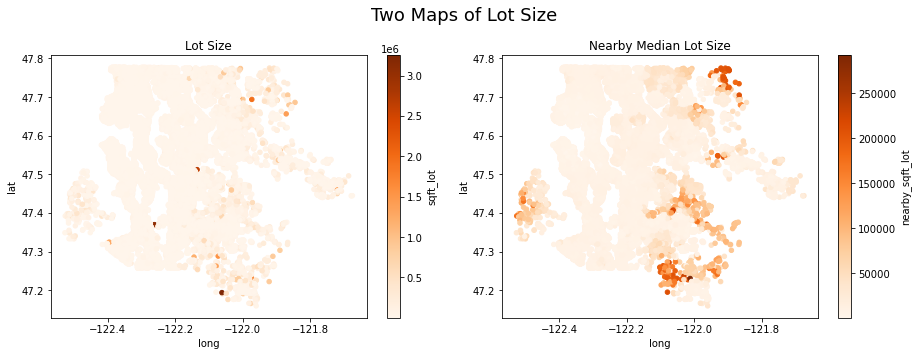

In [62]:
# display lot area (left) and nearby median lot area (right)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='sqft_lot', cmap='Oranges', ax=ax1, title='Lot Size')
df.plot.scatter(x='long', y='lat', c='nearby_sqft_lot', cmap='Oranges', ax=ax2, title='Nearby Median Lot Size')
fig.suptitle('Two Maps of Lot Size', size=18)
fig.tight_layout();

In [63]:
# create nearby price per square foot feature
df['nearby_ppsqft'] = df.apply(lambda x: nearby(x.neighbor_list, 'ppsqft'), axis=1)

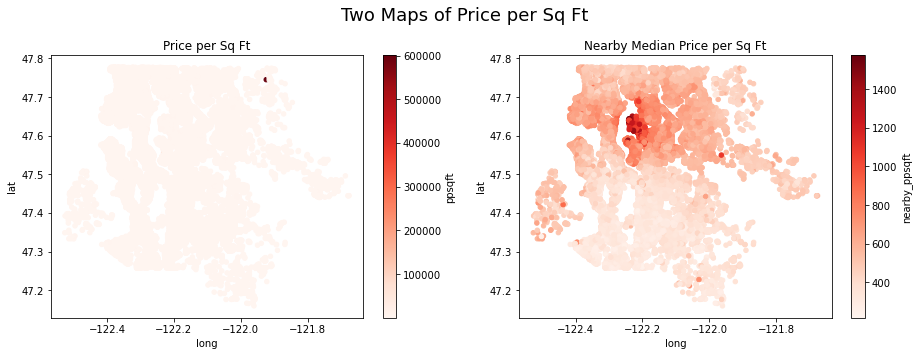

In [64]:
# display price per square foot (left) and nearby median price per square foot (right)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='ppsqft', cmap='Reds', ax=ax1, title='Price per Sq Ft')
df.plot.scatter(x='long', y='lat', c='nearby_ppsqft', cmap='Reds', ax=ax2, title='Nearby Median Price per Sq Ft')
fig.suptitle('Two Maps of Price per Sq Ft', size=18)
fig.tight_layout();

In [65]:
# create nearby age feature
df['nearby_age'] = df.apply(lambda x: nearby(x.neighbor_list, 'age'), axis=1)

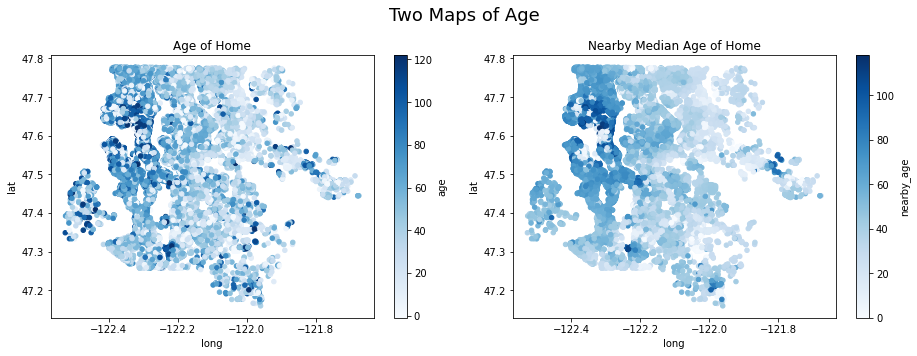

In [66]:
# display age (left) and nearby median age (right)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='age', cmap='Blues', ax=ax1, title='Age of Home')
df.plot.scatter(x='long', y='lat', c='nearby_age', cmap='Blues', ax=ax2, title='Nearby Median Age of Home')
fig.suptitle('Two Maps of Age', size=18)
fig.tight_layout();

As discussed at the very beginning, now we can interpolate missing values for heat source and sewer system. That is, for each listing with a missing value for heat source and/or sewer system, we'll assign the most popular value (mode) among that listing's neighbors.

In [67]:
# iterate over records with missing values and assign the modal value from their neighborhood list
for listing in df[df['sewer_system'].isna()].index:
    df.at[listing, 'sewer_system'] = df.loc[df.loc[listing]['neighbor_list']]['sewer_system'].mode()[0]
for listing in df[df['heat_source'].isna()].index:
    df.at[listing, 'heat_source'] = df.loc[df.loc[listing]['neighbor_list']]['heat_source'].mode()[0]

We can also use the neighbor list features to identify anomalous records that are possibly just errors. We can give each listing a score based on the factors by which it differs from its neighbors in certain values. For example, we'll see a listing whose living area ("3 sq ft") is orders of magnitude smaller than its neighbors.

(An earlier effort at this identified too many 'anomalies' by virtue of their exceptionally large lot areas, so we'll just look for exceptional values in price and living area.)

The "anom" function will get called in reference to a particular feature, such as price. The function will return the ratio of the anomaly, such as "5" if the price is either 5 times as expensive as the neighborhood median, or 5 times *less* expensive than the neighborhood median.

In [68]:
# as described above, this function returns the greater of two ratios, indicating by what factor the value 
# differs from its neighbor list
def anom(val, neighbor_val):
    return max(val/neighbor_val, neighbor_val/val)

Here we'll create new columns that hold the ratios found by the anom function.

In [69]:
df['anomalous_price'] = df.apply(lambda x: anom(x.price, x.nearby_price),axis=1)
df['anomalous_sqft_living'] = df.apply(lambda x: anom(x.sqft_living, x.nearby_sqft_living),axis=1)
df['anomalous_ppsqft'] = df.apply(lambda x: anom(x.ppsqft, x.nearby_ppsqft),axis=1)

In [70]:
# show how many prices differ from their neighbors by a factor of more than 15
len(df[df['anomalous_price'] > 15])

34

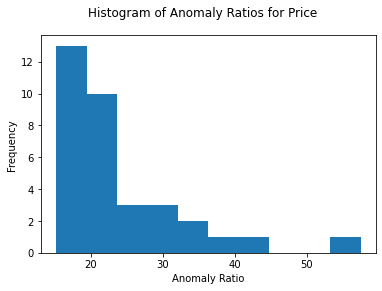

In [71]:
# display a histogram of some data that have particularly high anomaly ratios for price
ax = df[df['anomalous_price'] > 15]['anomalous_price'].plot(
    kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Anomaly Ratios for Price')
plt.xlabel('Anomaly Ratio');

Below, we'll see where the most anomalous prices are located on the map.

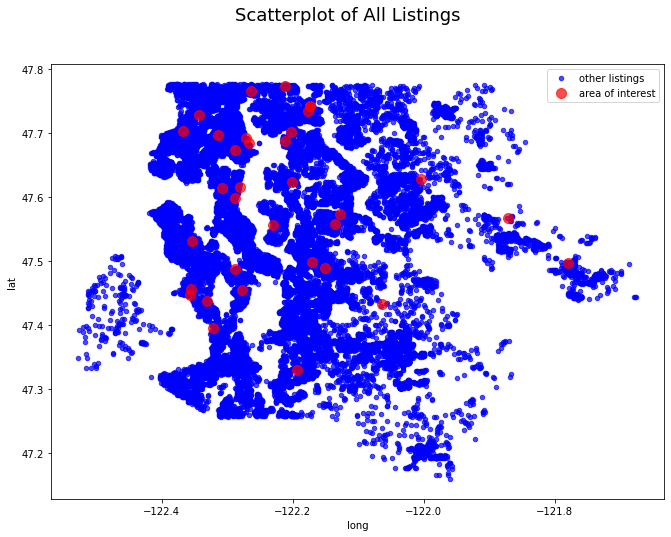

In [72]:
# show scatterplot of all listings, highlighting most anomalous price values
highlight = df.sort_values('anomalous_price', ascending=False)[:34].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(11,8))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='other listings')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='area of interest')

fig.suptitle('Scatterplot of All Listings', size=18)

ax.legend();

Here we'll look at the addresses of these anomalous prices.

In [73]:
df.sort_values('anomalous_price', ascending=False)[:34][['price', 'nearby_price', 'address', 'city', 'zip']]

,price,nearby_price,address,city,zip
6430,40000.0,2300000.0,"2030 250th Place Northeast, Sammamish, Washing...",Sammamish,98074
23470,30750000.0,706000.0,"1620 Lake Washington Boulevard, Seattle, Washi...",Seattle,98122
9125,29941.0,1117500.0,"15724 124th Avenue Northeast, Woodinville, Was...",Woodinville,98072
14544,35000.0,1210000.0,"412 35th Avenue South, Seattle, Washington 981...",Seattle,98144
7577,28307.0,950000.0,"15708 124th Avenue Northeast, Woodinville, Was...",Woodinville,98072
25830,30108.0,955000.0,"34920 Southeast Fall City-Snoqualmie Road, Fal...",Fall City,98024
21793,27563.0,852500.0,"1528 19th Avenue, Seattle, Washington 98122, U...",Seattle,98122
20406,28559.0,823500.0,"417 Hoquiam Place Northeast, Renton, Washingto...",Renton,98059
17140,54241.0,1456500.0,"15244 Southeast 49th Street, Bellevue, Washing...",Bellevue,98006
14797,50000.0,1253500.0,"6221 37th Avenue Northeast, Seattle, Washingto...",Seattle,98115


The prices that are way lower than normal (for their neighborhood) seem like mistakes, and the prices that are way higher than normal might just be mansions or expansive ranches.

It seems helpful to get rid of the likely mistakes (unusually low prices).

In [74]:
# drop records where the price is less than $100,000 and the anomaly ratio is more than 15
df.drop(df[
    (df['price'] < 100000) & (df['anomalous_price'] > 15)
].index, inplace=True)

As for the unusually high prices, we can perhaps address those as outliers of the greater data set, not just compared to their neighbors.

In [75]:
# set a threshold for how many standard deviations we wish to accept
threshold = 9.8
# create a list of indices for outlier values beyond the acceptable number of standard deviations
outliers = set(df[df['price'] > df['price'].mean() + threshold * df['price'].std()].index)
# show the results
print('There are', len(outliers), 'listings with a price of at least', min(df.loc[outliers]['price']))

There are 26 listings with a price of at least 10000000.0


Let's drop everything $10 million and above.

In [76]:
df.drop(df[df['price'] >= 10000000].index, inplace=True)

Now let's investigate anomalous living area values.

In [77]:
# show how many records have living area with an anomaly ratio greater than 3
len(df[df['anomalous_sqft_living'] > 3])

42

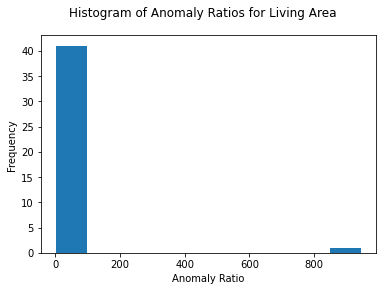

In [78]:
# show a histogram of living area values with an anomaly ratio greater than 3
ax = df[df['anomalous_sqft_living'] > 3]['anomalous_sqft_living'].plot(
    kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Anomaly Ratios for Living Area')
plt.xlabel('Anomaly Ratio');

Whoa. Let's get rid of the crazy outlier and try this again.

In [79]:
# drop the single huge outlier
df.drop(df[df['anomalous_sqft_living'] > 200].index, inplace=True)

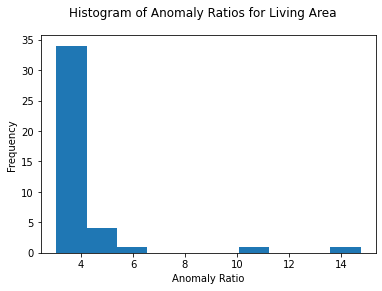

In [80]:
# show a histogram of greatest living area anomaly ratios
ax = df[df['anomalous_sqft_living'] > 3]['anomalous_sqft_living'].plot(
    kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Anomaly Ratios for Living Area')
plt.xlabel('Anomaly Ratio');

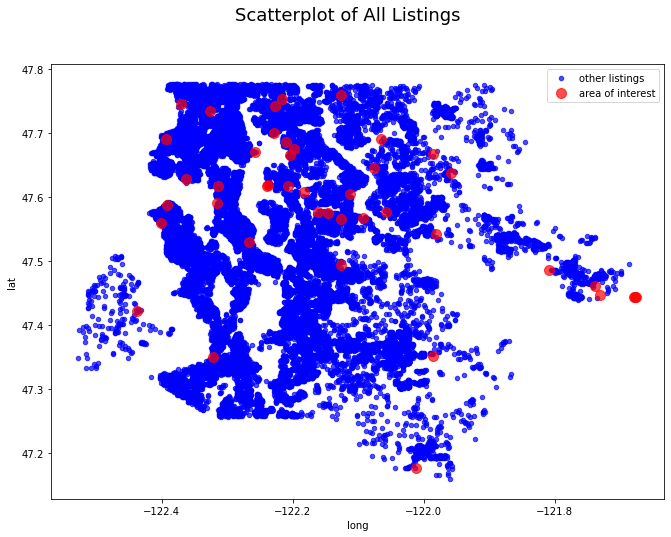

In [81]:
# show where the anomalous living area values are on the map

highlight = df.sort_values('anomalous_sqft_living', ascending=False)[:43].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(11,8))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='other listings')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='area of interest')

fig.suptitle('Scatterplot of All Listings', size=18)

ax.legend();

In [82]:
# show the addresses and other features of the most anomalous living area values
df.sort_values('anomalous_sqft_living', ascending=False)[:41][[
    'sqft_living', 'nearby_sqft_living', 'bedrooms', 'address', 'city', 'zip']]

,sqft_living,nearby_sqft_living,bedrooms,address,city,zip
28816,100,1475.0,1,"49622 172nd Street Southeast, North Bend, Wash...",North Bend,98045
14827,7710,755.0,0,"1727 15th Avenue, Seattle, Washington 98122, U...",Seattle,98122
3431,290,1680.0,1,"160 118th Avenue Southeast, Bellevue, Washingt...",Bellevue,98005
5219,10750,2105.0,5,"450 West Lake Sammamish Parkway Southeast, Bel...",Bellevue,98008
10158,670,3140.0,3,"18212 160th Ave NE, Woodinville, Washington 98...",Woodinville,98072
7119,7390,1640.0,5,"12048 160th Avenue Southeast, Renton, Washingt...",Renton,98059
28815,170,755.0,0,"49702 172nd Street Southeast, North Bend, Wash...",North Bend,98045
1948,12300,2980.0,5,"4121 198th Court Northeast, Sammamish, Washing...",Sammamish,98074
6125,400,1590.0,1,"16010 Southeast 45th Street, Bellevue, Washing...",Bellevue,98006
300,7820,1990.0,3,"4750 54th Avenue Southwest, Seattle, Washingto...",Seattle,98116


In [83]:
# show only the most extreme 20 values
df.sort_values('sqft_living', ascending=True)[['sqft_living', 'bedrooms', 'price']][:20]

,sqft_living,bedrooms,price
28816,100,1,205000.0
28815,170,0,205000.0
25133,210,0,525000.0
8694,260,0,1160000.0
8391,290,0,1625000.0
23622,290,0,960000.0
3431,290,1,2500000.0
11989,310,1,695000.0
476,320,1,405000.0
13015,320,0,489962.0


Any dwelling under 500 sqft seems quite small, and anything under 250 seems nearly impossible. The number of bedrooms seems right for small dwellings (all 0 or 1) but some of these tiny studio apartments seem to be fetching sums of more than 1 million. Let's drop all dwellings under 250 sqft, anything under 325 that's selling for 750,000+, and anything under 425 that's over 1 million.

In [84]:
df.drop(df[
    (df['sqft_living'] < 250) |
    (df['sqft_living'] < 325) &
    (df['price'] > 750000) |
    (df['sqft_living'] < 425) &
    (df['price'] > 1000000)
].index, inplace=True)

Let's check out the largest dwellings.

In [85]:
df.sort_values('sqft_living', ascending=False)[['sqft_living', 'bedrooms', 'price']][:30]

,sqft_living,bedrooms,price
9888,15360,13,3750000.0
25490,13540,7,3580000.0
635,12540,6,8500000.0
1948,12300,5,4350000.0
4411,10910,6,3495000.0
5219,10750,5,8400000.0
708,9627,7,3700000.0
4570,9440,5,4940000.0
20817,8882,6,4250000.0
22294,8680,7,9800000.0


Since living area is likely going to factor importantly into our model, we may wish to trim the most extreme values here. Let's drop anything over 8000.

In [86]:
df.drop(df[
    (df['sqft_living'] > 8000)
].index, inplace=True)

Also, the "zero-bedroom" home with over 7,000 square foot living area seems suspicious. Let's look at these "zero-bedrooms".

In [87]:
# show data for all "zero bedrooms"
df[df['bedrooms'] == 0]['sqft_living'].describe()

count      35.000000
mean     1314.142857
std      1225.951615
min       320.000000
25%       695.000000
50%      1255.000000
75%      1535.500000
max      7710.000000
Name: sqft_living, dtype: float64

In [88]:
# show more features for "zero bedroom" homes
df[df['bedrooms'] == 0].sort_values('sqft_living', ascending=False)[['sqft_living', 'address']][:10]

,sqft_living,address
14827,7710,"1727 15th Avenue, Seattle, Washington 98122, U..."
11471,2380,"164 Northeast 145th Street, Shoreline, Washing..."
7545,1940,"7453 Gatewood Road Southwest, Seattle, Washing..."
25994,1768,"6011 Roosevelt Way Northeast, Seattle, Washing..."
17536,1768,"6029 Roosevelt Way Northeast, Seattle, Washing..."
27540,1738,"6021 Roosevelt Way Northeast, Seattle, Washing..."
1952,1677,"43407 212th Avenue Southeast, Enumclaw, Washin..."
573,1617,"6019 Roosevelt Way Northeast, Seattle, Washing..."
20643,1541,"7749B 15th Ave NW, Seattle, Washington 98117, ..."
29574,1530,"829 Whitman Avenue North, Shoreline, Washingto..."


While a zero-bedroom could certainly mean a "studio" apartment, A cursory look on Zillow confirms that most of these are erroneously valued and actually have multiple bedrooms. As there are only 34 such entries in total, it seems fair to drop them all.

In [89]:
# drop all zero bedroom homes
df.drop(df[df['bedrooms'] == 0].index, inplace=True)

## Looking at Zip Codes and Cities

Let's look at how many cities and how many zip codes fall into each price bracket.

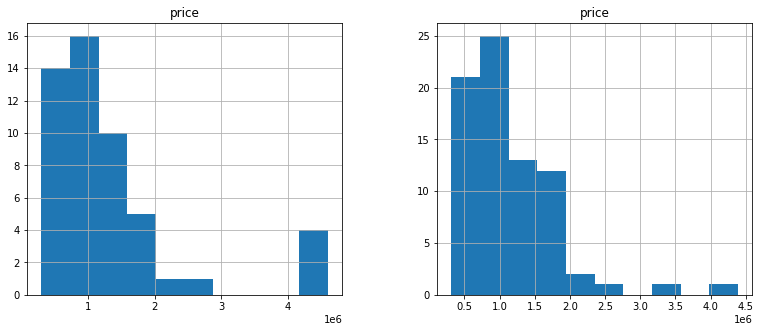

In [90]:
# show histograms of cities (left) and zip codes (right) grouped in bins by mean price

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.groupby('city').agg({'price': 'mean'}).hist(ax=ax1)
df.groupby('zip').agg({'price': 'mean'}).hist(ax=ax2);

It would seem best to carve up the cities into about 5 tiers and the zip codes into about 8.

In [91]:
# create a temporary dataframe that groups records by city and finds the mean
df_city = df.groupby('city')['price'].mean()
# establish the desired number of levels or tiers for cities
num_tiers = 5
# make an empty list that will be populated with lists of cities in each tier
city_tier = []
# iterate over the number of tiers and add cities to their corresponding tiers according to price quantile
for q in range(num_tiers):
    city_tier.append([])
    lower = df['price'].quantile(q/num_tiers)
    upper = df['price'].quantile((q+1)/num_tiers)
    city_tier[q] = list(df_city[(df_city > lower) & (df_city < upper)].index)

# this function assigns a tier to a listing based on its city and the above calculations
def city_tiering(city):
    for q in range(num_tiers):
        if city in city_tier[q]:
            return q

# create city tier feature by applying lambda function that uses city_tiering function
df['city_tier'] = df['city'].apply(lambda x: city_tiering(x))

In [92]:
# show how many listings were captures in each of 5 city tiers
df['city_tier'].value_counts()

3    11029
4     6632
1     6249
2     4564
0      585
Name: city_tier, dtype: int64

We have created 5 city tiers (0 through 4), each of which captures between 585 and 11029 listings. The most populous tier is tier 3, because it includes all of Seattle's population.

In [93]:
df[df['city_tier'] == 3]['city'].value_counts()

Seattle             9329
North Bend           465
Kenmore              346
Snoqualmie           291
Bothell              263
Lake Forest Park     218
Normandy Park        112
Hobart                 4
Ames Lake              1
Name: city, dtype: int64

In [94]:
# create a temporary dataframe that groups records by zip code and finds the mean
df_zip = df.groupby('zip')['price'].mean()
# establish the desired number of levels or tiers for zip codes
num_tiers = 8
# make an empty list that will be populated with lists of zip codes in each tier
zip_tier = []
# iterate over the number of tiers and add zip codes to their corresponding tiers according to price quantile
for q in range(num_tiers):
    zip_tier.append([])
    lower = df['price'].quantile(q/num_tiers)
    upper = df['price'].quantile((q+1)/num_tiers)
    zip_tier[q] = list(df_zip[(df_zip > lower) & (df_zip < upper)].index)

# this function assigns a tier to a listing based on its zip code and the above calculations
def zip_tiering(zip_code):
    for q in range(num_tiers):
        if zip_code in zip_tier[q]:
            return q

# create zip tier feature by applying lambda function that uses zip_tiering function
df['zip_tier'] = df['zip'].apply(lambda x: zip_tiering(x))

In [95]:
# show how many listings were captures in each of 5 zip tiers
df['zip_tier'].value_counts()

5    6317
6    4586
2    4022
1    4004
3    3555
4    3403
7    2730
0     442
Name: zip_tier, dtype: int64

We have created 8 zip code tiers that include between 442 and 6317 listings each. This is a bit more evenly distributed than the city tiers.

## Exploring Multicollinearity

Now we need to look at what features may demonstrate multicollinearity, which essentially means that two features are so closely related that they effectively introduce redundancy into our regression calculations.

In [96]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_mc=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_mc['pairs'] = list(zip(df_mc.level_0, df_mc.level_1))

# set index to pairs
df_mc.set_index(['pairs'], inplace = True)

# drop level columns
df_mc.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_mc.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themse
# for the sake of exercise, kept it in.
df_mc.drop_duplicates(inplace=True)

Below, we'll look at the most closely correlated features.

In [97]:
df_mc[(df_mc.cc > .62) & (df_mc.cc < 1)]

,cc
pairs,
"(yr_built, age)",0.999885
"(age, years_since_renovation)",0.908715
"(yr_built, years_since_renovation)",0.908503
"(sqft_living, sqft_above)",0.876927
"(zip_tier, city_tier)",0.852357
"(zip_tier, nearby_ppsqft)",0.806834
"(anomalous_ppsqft, anomalous_price)",0.798831
"(bathrooms, sqft_living)",0.776388
"(price, nearby_price)",0.762580


Most notable here are a few strong predictors of price (nearby_ppsqft, nearby_price) and a few likely instances of actual multicollinearity, namely sqft_living paired with each of sqft_above, bathrooms, and grade.

## Exploring Log Transformations

Now we'll look at what effect might come from log transforming several of our features.

In [98]:
# create a feature that is the log of the price
df['log_price'] = np.log(df['price'])

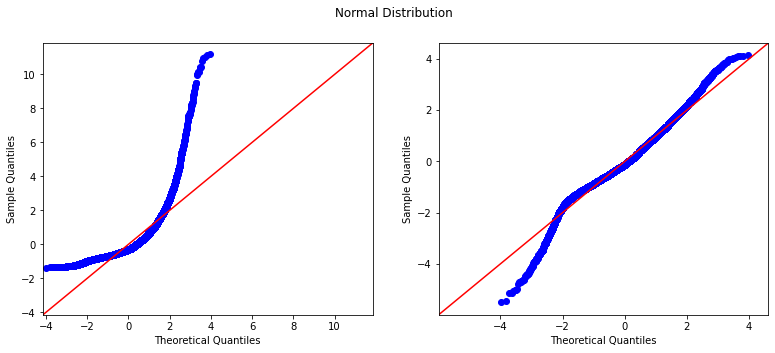

In [99]:
# Use qqplot function from StatsModels
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))
sm.graphics.qqplot(df['price'], line='45', fit=True, ax=ax1)
sm.graphics.qqplot(df['log_price'], line='45', fit=True, ax=ax2)

fig.suptitle("Normal Distribution");

The Q-Q plot shows that the log transformed values are much closer to a normal distribution. This suggests that we will get better results from our regression model if we log transform this feature.

The histogram below demonstrates this as well.

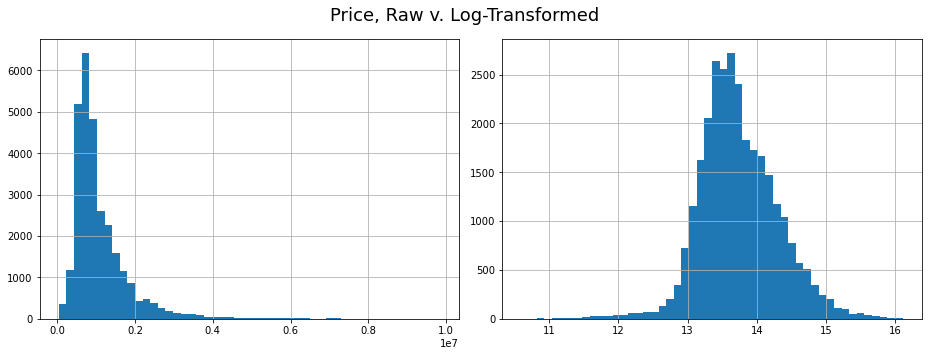

In [100]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df['price'].hist(ax = ax1, bins=50)
df['log_price'].hist(ax = ax2, bins=50)

fig.suptitle('Price, Raw v. Log-Transformed', size=18)
fig.tight_layout();

Log-transforming the price clearly gives us a closer to normal set of target values to work with.

Let's consider which of the features possibly warrant log-transforming.

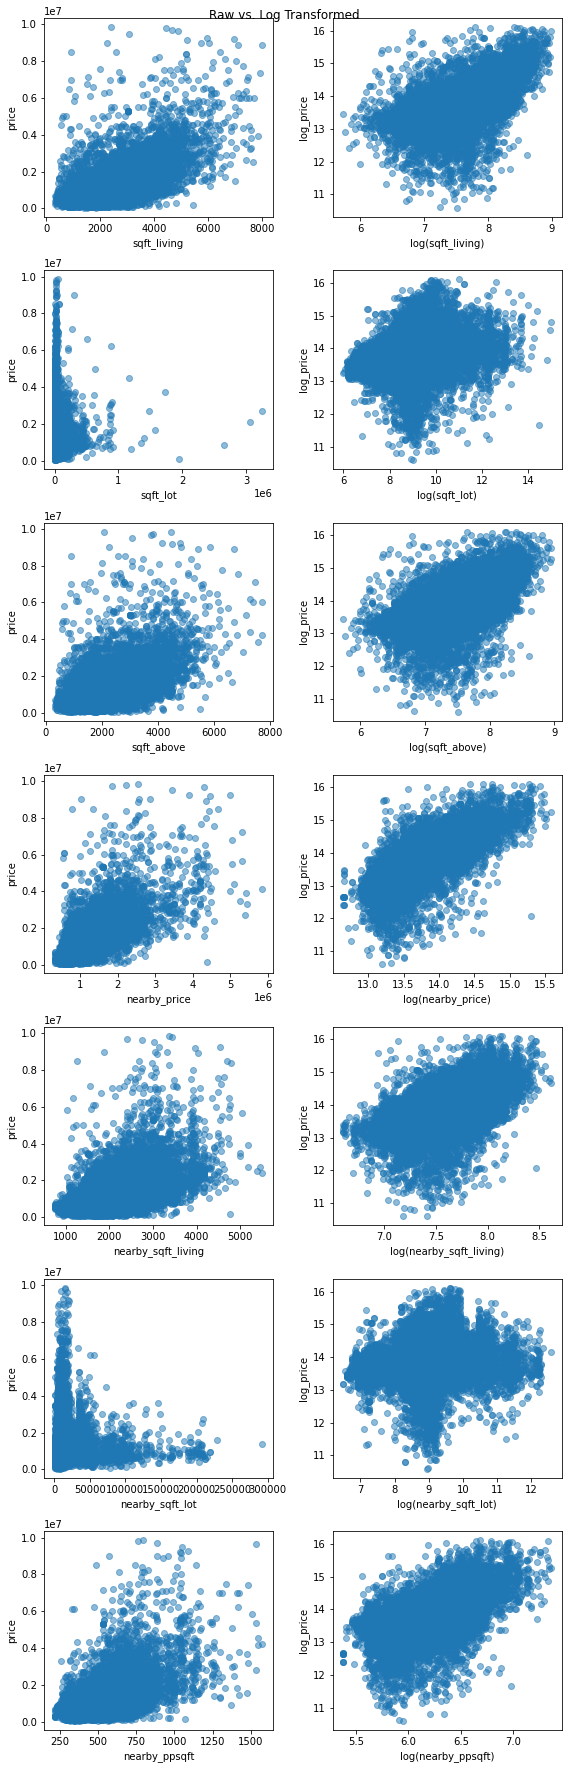

In [101]:
# set aside a list of candidates to look at (numerical continuous features only)
log_candidates = ['sqft_living', 'sqft_lot', 'sqft_above', 'nearby_price',
       'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft']

y = df['price']

fig, axes = plt.subplots(ncols=2, nrows=len(log_candidates), figsize=(8,25))

for i, column in enumerate(log_candidates):
    # Plot raw version
    left_ax = axes[i][0]
    left_ax.scatter(df[column], y, alpha=0.5)
    left_ax.set_xlabel(column)
    left_ax.set_ylabel('price')
    
    # Plot log transformed version
    right_ax = axes[i][1]
    right_ax.scatter(np.log(df[column]), np.log(y), alpha=0.5)
    right_ax.set_xlabel(f"log({column})")
    right_ax.set_ylabel("log_price")
    
fig.suptitle("Raw vs. Log Transformed")

fig.tight_layout();

It appears that *any*thing that's measured in square feet also looks better against the target variable when log-transformed. The clearest examples are:
- sqft_living
- nearby_price
- nearby_sqft_living
- nearby_ppsqft

We'll add log columns for those features.

In [102]:
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_nearby_price'] = np.log(df['nearby_price'])
df['log_nearby_sqft_living'] = np.log(df['nearby_sqft_living'])
df['log_nearby_ppsqft'] = np.log(df['nearby_ppsqft'])

Now we'll explore how features correlate to log transformed values.

In [103]:
corr_columns = ['price', 'log_price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
                'yr_built', 'yr_renovated', 'ppsqft', 'age', 'years_since_renovation',
                'nearby_price', 'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft',
                'nearby_age', 'log_sqft_living', 'log_nearby_price',
                'log_nearby_sqft_living', 'log_nearby_ppsqft']

In [104]:
df[corr_columns].corr()[['price', 'log_price']]

,price,log_price
price,1.000000,0.886642
log_price,0.886642,1.000000
bedrooms,0.320503,0.350474
bathrooms,0.506299,0.519819
sqft_living,0.643450,0.631344
sqft_lot,0.091169,0.085101
floors,0.219946,0.259583
sqft_above,0.567688,0.552968
sqft_basement,0.235952,0.241563
sqft_garage,0.280540,0.284022


Curiously, the log transformed values don't correlate much better than the untransformed values.

## Column Maintenance
Before we explore interactions between variables, we want to create more features to potentially interact.

We'll want to create duplicates ("dupes") of the zip tier and city tier features before we perform one-hot encoding, in case we want to access the original zip tier information later.

In [105]:
df['zip_tier_dupe'] = df['zip_tier']

In [106]:
df['city_tier_dupe'] = df['city_tier']

In [107]:
# one-hot encode all categorical values
df = pd.get_dummies(df, columns = [
    'waterfront', 'greenbelt', 'nuisance', 'city', 'city_tier', 'zip', 'zip_tier'])
df.drop(columns = ['waterfront_NO', 'greenbelt_NO', 'nuisance_NO',
                   'zip_98422', 'city_White Center', 'city_tier_0', 'zip_tier_0'], axis = 1, inplace = True)

In [108]:
# display heat source value counts
df['heat_source'].value_counts()

Gas                  20077
Electricity           5919
Oil                   2891
Gas/Solar               92
Electricity/Solar       57
Other                   19
Oil/Solar                4
Name: heat_source, dtype: int64

The "sewer system" feature also has just 8 instances of "restricted" service, whatever that means.

In [109]:
df['sewer_system'].value_counts()

PUBLIC                24744
PRIVATE                4307
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

We'll fix these so that we have (slightly overlapping) categorical variables for each. That is, the heat source will effectively be one-hot encoded, except that the listings that have multiple sources (e.g. "Gas/Solar") will have "1" entries for both heat sources. And the sewer system data will be processed in such a way that there will be a feature for "private" (1 if private, 0 if public) and another feature for "restricted" (1 if restricted, 0 if not).

In [110]:
df['gas'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Gas' else 0)
df['electricity'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Ele' else 0)
df['oil'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Oil' else 0)
df['solar'] = df['heat_source'].apply(lambda x: 1 if str(x)[-5:] == 'Solar' else 0)

df['sewer_system_private'] = df[
    'sewer_system'].apply(lambda x: 1 if str(x)[:7] == 'PRIVATE' else 0)
df['sewer_system_restricted'] = df[
    'sewer_system'].apply(lambda x: 1 if str(x)[-10:] == 'RESTRICTED' else 0)

Finally, we'll create some helpful groups for all of the columns we may wish to include in our model.

In [111]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
                      'age', 'years_since_renovation']
nearby = ['nearby_price', 'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft', 'nearby_age']
logs = ['log_sqft_living', 'log_nearby_price', 'log_nearby_sqft_living', 'log_nearby_ppsqft']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition',
                    'grade', 'city_tier_dupe', 'zip_tier_dupe']
categorical = ['waterfront_YES', 'greenbelt_YES', 'nuisance_YES']
utilities = ['gas', 'electricity', 'oil', 'solar', 'sewer_system_private', 'sewer_system_restricted']
cities = ['city_Algona', 'city_Ames Lake', 'city_Auburn', 'city_Beaux Arts', 'city_Bellevue', 'city_Black Diamond',
          'city_Bothell', 'city_Burien', 'city_Carnation', 'city_Clyde Hill', 'city_Cottage Lake', 'city_Covington',
          'city_Dash Point', 'city_Des Moines', 'city_Dilworth', 'city_Duvall', 'city_Enumclaw', 'city_Fairwood',
          'city_Fall City', 'city_Federal Way', 'city_Hobart', 'city_Hunts Point', 'city_Issaquah', 'city_Kenmore',
          'city_Kent', 'city_Kirkland', 'city_Lake Forest Park', 'city_Lakeland North', 'city_Maple Valley',
          'city_Medina', 'city_Mercer Island', 'city_Milton', 'city_Newcastle', 'city_Normandy Park',
          'city_North Bend', 'city_Pacific', 'city_Preston', 'city_Ravensdale', 'city_Redmond', 'city_Renton',
          'city_Sammamish', 'city_SeaTac', 'city_Seattle', 'city_Shoreline', 'city_Snoqualmie', 'city_Tukwila',
          'city_Union Hill-Novelty Hill', 'city_Vashon', 'city_Woodinville', 'city_Yarrow Point']
zips = ['zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
        'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024', 'zip_98027',
        'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038',
        'zip_98039', 'zip_98040', 'zip_98042', 'zip_98045', 'zip_98047', 'zip_98050', 'zip_98051', 'zip_98052',
        'zip_98053', 'zip_98055', 'zip_98056', 'zip_98057', 'zip_98058', 'zip_98059', 'zip_98065', 'zip_98070',
        'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105',
        'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117',
        'zip_98118', 'zip_98119', 'zip_98122', 'zip_98125', 'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144',
        'zip_98146', 'zip_98148', 'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178', 'zip_98188',
        'zip_98198', 'zip_98199', 'zip_98354']
tiers = ['zip_tier_1', 'zip_tier_2', 'zip_tier_3', 'zip_tier_4', 'zip_tier_5', 'zip_tier_6', 'zip_tier_7',
        'city_tier_1', 'city_tier_2', 'city_tier_3', 'city_tier_4', 'city_tier_5']

## Exploring Interactions Between Variables
It will be helpful to know if there are any variables that *interact* significantly with one another. The most likely scenario in which this would happen is if price correlated with living area *at different rates* depending on another variable, such as what zip code the home belonged to.

First, we'll make scatterplots of the listing with living area on one axis and price on the other, color-coding the dots according to their zip code level or city level.

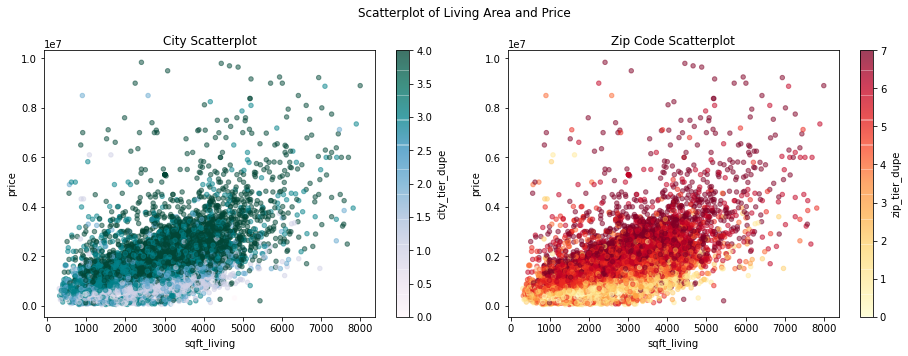

In [112]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(13,5))

df.plot.scatter(x='sqft_living', y='price', c='city_tier_dupe', cmap='PuBuGn', alpha=0.5, ax=ax1,
                title='City Scatterplot')

df.plot.scatter(x='sqft_living', y='price', c='zip_tier_dupe', cmap='YlOrRd', alpha=0.5, ax=ax2,
               title='Zip Code Scatterplot')

fig.suptitle('Scatterplot of Living Area and Price')

fig.tight_layout();

Let's plot fit lines for all the different zip code tiers against each other (and over a scatterplot of all the data).

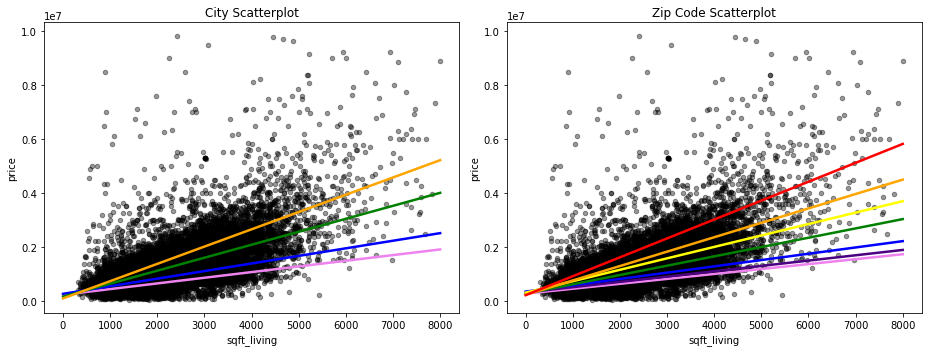

In [113]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(13,5))
df.plot.scatter(x='sqft_living', y='price', alpha=0.4, ax=ax1, color='black',
                title='City Scatterplot')
df.plot.scatter(x='sqft_living', y='price', alpha=0.4, ax=ax2, color='black',
                title='Zip Code Scatterplot')

xseq = np.linspace(0, 8000, num=100)

dft1 = df[df['city_tier_dupe'] == 1][['price', 'sqft_living']]
dft2 = df[df['city_tier_dupe'] == 2][['price', 'sqft_living']]
dft3 = df[df['city_tier_dupe'] == 3][['price', 'sqft_living']]
dft4 = df[df['city_tier_dupe'] == 4][['price', 'sqft_living']]
# dft5 = df[df['city_tier_dupe'] == 5][['price', 'sqft_living']]

b1, a1 = np.polyfit(dft1['sqft_living'], dft1['price'], deg=1)
b2, a2 = np.polyfit(dft2['sqft_living'], dft2['price'], deg=1)
b3, a3 = np.polyfit(dft3['sqft_living'], dft3['price'], deg=1)
b4, a4 = np.polyfit(dft4['sqft_living'], dft4['price'], deg=1)
# b5, a5 = np.polyfit(dft5['sqft_living'], dft5['price'], deg=1)

ax1.plot(xseq, a1 + b1 * xseq, color='violet', lw=2.5)
ax1.plot(xseq, a2 + b2 * xseq, color='blue', lw=2.5)
ax1.plot(xseq, a3 + b3 * xseq, color='green', lw=2.5)
ax1.plot(xseq, a4 + b4 * xseq, color='orange', lw=2.5)
# ax1.plot(xseq, a5 + b5 * xseq, color='red', lw=2.5)

dft1 = df[df['zip_tier_dupe'] == 1][['price', 'sqft_living']]
dft2 = df[df['zip_tier_dupe'] == 2][['price', 'sqft_living']]
dft3 = df[df['zip_tier_dupe'] == 3][['price', 'sqft_living']]
dft4 = df[df['zip_tier_dupe'] == 4][['price', 'sqft_living']]
dft5 = df[df['zip_tier_dupe'] == 5][['price', 'sqft_living']]
dft6 = df[df['zip_tier_dupe'] == 6][['price', 'sqft_living']]
dft7 = df[df['zip_tier_dupe'] == 7][['price', 'sqft_living']]

b1, a1 = np.polyfit(dft1['sqft_living'], dft1['price'], deg=1)
b2, a2 = np.polyfit(dft2['sqft_living'], dft2['price'], deg=1)
b3, a3 = np.polyfit(dft3['sqft_living'], dft3['price'], deg=1)
b4, a4 = np.polyfit(dft4['sqft_living'], dft4['price'], deg=1)
b5, a5 = np.polyfit(dft5['sqft_living'], dft5['price'], deg=1)
b6, a6 = np.polyfit(dft6['sqft_living'], dft6['price'], deg=1)
b7, a7 = np.polyfit(dft7['sqft_living'], dft7['price'], deg=1)

ax2.plot(xseq, a1 + b1 * xseq, color='violet', lw=2.5)
ax2.plot(xseq, a2 + b2 * xseq, color='indigo', lw=2.5)
ax2.plot(xseq, a3 + b3 * xseq, color='blue', lw=2.5)
ax2.plot(xseq, a4 + b4 * xseq, color='green', lw=2.5)
ax2.plot(xseq, a5 + b5 * xseq, color='yellow', lw=2.5)
ax2.plot(xseq, a6 + b6 * xseq, color='orange', lw=2.5)
ax2.plot(xseq, a7 + b7 * xseq, color='red', lw=2.5)

fig.tight_layout();

This makes a strong case for interaction between sqft_living and the various city or zip code tiers.

Now we'll make a similar comparison for waterfront listings.

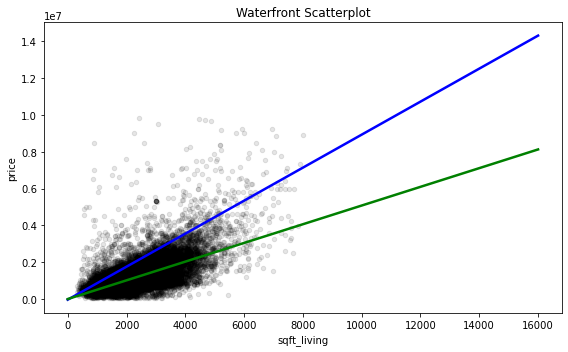

In [114]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot.scatter(x='sqft_living', y='price', alpha=0.1, ax=ax, color='black', title='Waterfront Scatterplot')

xseq = np.linspace(0, 16000, num=100)

df_water = df[df['waterfront_YES'] == 1][['price', 'sqft_living']]
df_land = df[df['waterfront_YES'] == 0][['price', 'sqft_living']]

b1, a1 = np.polyfit(df_water['sqft_living'], df_water['price'], deg=1)
b2, a2 = np.polyfit(df_land['sqft_living'], df_land['price'], deg=1)



ax.plot(xseq, a1 + b1 * xseq, color='blue', lw=2.5)
ax.plot(xseq, a2 + b2 * xseq, color='green', lw=2.5)

fig.tight_layout();

This seems like another clear interaction case. Let's look at the "view" feature.

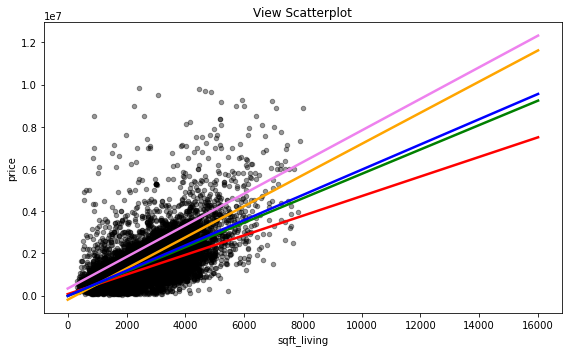

In [115]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot.scatter(x='sqft_living', y='price', alpha=0.4, ax=ax, color='black', title='View Scatterplot')

xseq = np.linspace(0, 16000, num=100)

dft1 = df[df['view'] == 0][['price', 'sqft_living']]
dft2 = df[df['view'] == 1][['price', 'sqft_living']]
dft3 = df[df['view'] == 2][['price', 'sqft_living']]
dft4 = df[df['view'] == 3][['price', 'sqft_living']]
dft5 = df[df['view'] == 4][['price', 'sqft_living']]

b1, a1 = np.polyfit(dft1['sqft_living'], dft1['price'], deg=1)
b2, a2 = np.polyfit(dft2['sqft_living'], dft2['price'], deg=1)
b3, a3 = np.polyfit(dft3['sqft_living'], dft3['price'], deg=1)
b4, a4 = np.polyfit(dft4['sqft_living'], dft4['price'], deg=1)
b5, a5 = np.polyfit(dft5['sqft_living'], dft5['price'], deg=1)

ax.plot(xseq, a1 + b1 * xseq, color='red', lw=2.5)
ax.plot(xseq, a2 + b2 * xseq, color='orange', lw=2.5)
ax.plot(xseq, a3 + b3 * xseq, color='green', lw=2.5)
ax.plot(xseq, a4 + b4 * xseq, color='blue', lw=2.5)
ax.plot(xseq, a5 + b5 * xseq, color='violet', lw=2.5)

fig.tight_layout();

This does *not* look like a good candidate for interaction. A good candidate would have distinct slopes for each subgroup, but the slopes of these lines are too similar to each other.
## Adding Interaction Terms
We'll create the interaction terms and add them to their own column group

In [116]:
df['city_interaction'] = df['sqft_living'] * df['city_tier_dupe']
df['zip_interaction'] = df['sqft_living'] * df['zip_tier_dupe']
df['water_interaction'] = df['sqft_living'] * df['waterfront_YES']
interactions = ['city_interaction', 'zip_interaction', 'water_interaction']

# Modeling
## Baseline Model — Living Area Only

Let's review the strongest correlations and choose what feature(s) to include in a simple baseline.

In [117]:
df.corr()[['price']].sort_values('price')[-10:]

,price
sqft_above,0.567688
ppsqft,0.571254
grade,0.608972
sqft_living,0.643450
log_nearby_price,0.727671
nearby_price,0.762580
city_interaction,0.764569
zip_interaction,0.793904
log_price,0.886642
price,1.000000


We obviously can't use log_price as a feature, as that would involve the target as a feature. But nearby_price should be fair game.

The strongest correlation among the original features is with sqft_living.

Let's make a simple baseline using sqft_living only.

In [118]:
y = df['price']
X_baseline = df[['sqft_living']]

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                 2.053e+04
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.2770e+05
No. Observations:               29059   AIC:                         8.554e+05
Df Residuals:                   29057   BIC:                         8.554e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.017e+04   8626.779     -3.498      

0.421 is not great, but it's good start to compare future models to.
## Nearby Features Model
Here we'll look at living area together with some of the "nearby" features we created.

We'll also standardize the values so that we can make apples-to-apples comparisons across coefficients.

In [119]:
y = df['price']
X_nearby = df[nearby].copy()

for col in X_nearby:
    X_nearby[col] = (X_nearby[col] - X_nearby[col].mean()) / X_nearby[col].std()

X_nearby_model = sm.OLS(y, sm.add_constant(X_nearby))
X_nearby_results = X_nearby_model.fit()

print(X_nearby_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     8115.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.2276e+05
No. Observations:               29059   AIC:                         8.455e+05
Df Residuals:                   29053   BIC:                         8.456e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 1.1e+06   2954

This shows that nearby price is a strong predictor compared to all the others, especially nearby lot area, which was not significant.
## Kitchen Sink Model
Here we'll include everything that came with the original data set together with the adjusted features ("age", "years since renovation") and the created feature of "zip tiers".

We'll also standardize the values again.

In [120]:
y = df['price']
X_kitchen_sink = pd.concat([
    df[numeric_continuous], df[numeric_discrete], df[categorical], df[utilities]],
    axis=1)

for col in X_kitchen_sink:
    X_kitchen_sink[col] = (X_kitchen_sink[col] - X_kitchen_sink[col].mean()) / X_kitchen_sink[col].std()

kitchen_sink_model = sm.OLS(y, sm.add_constant(X_kitchen_sink))
kitchen_sink_results = kitchen_sink_model.fit()

print(kitchen_sink_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     2192.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.2006e+05
No. Observations:               29059   AIC:                         8.402e+05
Df Residuals:                   29033   BIC:                         8.404e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

It's a much better R^2 at 0.652, but that's surely because we've piled so much into it. Let's focus on what we can learn from this model:

#### Bad p-values:
Nuisance and most of the utilities information can be dropped on this basis.

#### Curiously Negative Coefficients:
Why would *more* garage area, bedrooms, or floors be a *bad* thing? Something odd or at least unhelpful is happening with those features. We'll drop them.

It's also not clear why "age" has a positive coefficient. We'll keep an eye on that in future models.

#### High and Low Coefficients:
Greenbelt and solar power have the lowest coefficients among the ones we're still considering. They can be dropped.

## Kitchen Sink "Lean" Model
We'll run a similarly large number of features, but stripping out the ones just discussed.

We should also drop the features that we discovered to be multicollinear with living area: sqft_above, bathrooms, and grade.

In [121]:
y = df['price']
X_kitchen_sink_lean = X_kitchen_sink.copy().drop([
    'gas', 'electricity', 'oil', 'solar', 'sewer_system_restricted',
    'sqft_garage', 'bedrooms', 'floors', 'greenbelt_YES', 'nuisance_YES', 'sqft_above', 'bathrooms', 'grade'],
    axis=1)

kitchen_sink_lean_model = sm.OLS(y, sm.add_constant(X_kitchen_sink_lean))
kitchen_sink_lean_results = kitchen_sink_lean_model.fit()

print(kitchen_sink_lean_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     4141.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.2097e+05
No. Observations:               29059   AIC:                         8.420e+05
Df Residuals:                   29046   BIC:                         8.421e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     1.

Once again, there's a curiously negative coefficient (basement area), and some coefficients lower than the others (condition, patio area, lot area, and years since renovation). Those could be dropped in future models.

## Geography-Interactions Model
First we'll look at a model that uses *only* living area, label-encoded zip code tiers, and the waterfront feature.

Then we'll compare this to a model that adds interactions for those features.

In [122]:
y = df['price']
X_geography = pd.concat([df[['sqft_living', 'city_tier_dupe', 'zip_tier_dupe', 'waterfront_YES']]], axis=1)

X_geography_model = sm.OLS(y, sm.add_constant(X_geography))
X_geography_results = X_geography_model.fit()

print(X_geography_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 1.133e+04
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.2181e+05
No. Observations:               29059   AIC:                         8.436e+05
Df Residuals:                   29054   BIC:                         8.437e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.437e+05   8926.961    -60.

In [123]:
y = df['price']
X_geography_interactions = pd.concat([df[['sqft_living', 'city_tier_dupe', 'zip_tier_dupe', 'waterfront_YES']],
                                      df[interactions]], axis=1)

X_geography_interactions_model = sm.OLS(y, sm.add_constant(X_geography_interactions))
X_geography_interactions_results = X_geography_interactions_model.fit()

print(X_geography_interactions_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     8457.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.1932e+05
No. Observations:               29059   AIC:                         8.387e+05
Df Residuals:                   29051   BIC:                         8.387e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.003e+05   1.75e+0

The interactions have a significant effect on the R^2 value. Interestingly, the actual waterfront_YES variable by itself doesn't seem to be significant.

It's possible that the "city" and "zip" parts are confusing each other. We shouldn't have to do a multicollinearity check to know that we should only use "city" or "zip" and not both. From everything so far, it seems that zip code may be more helpful to the model.
## Final Model
This model takes what we've learned from the other models and uses only the strongest features.

In playing around with the features for this model, we found that we could strip away the bare "sqft_living" term without any loss — its effect is still seen in both of the interaction terms.

For the final model, we will shift some but *not* scale any of the features. The point of zero-shifting is to give better meaning to the y-intercept. The point of not scaling is so that we still have a notion of "rate" for each coefficient in the model.

In [124]:
df[['price', 'nearby_price', 'sqft_living']].mean()

price           1.099559e+06
nearby_price    1.012940e+06
sqft_living     2.124756e+03
dtype: float64

To make our explanations easier, let's zero-shift anything involving sqft_living (the two interaction features) to a living area of 2,000 sq ft, and zero-shift the nearby price feature to an even \$1,000,000.

This way, our y-intercept will represent "A 2,000 sq ft home, not on the waterfront, with no view, a public sewer system, and a median neighbor home price of \$1,000,000".

(We could have chosen any values for these baseline features, but something at least moderately plausible will be less confusing than having to explain, for example, what a negative y-intercept represents.)

In [125]:
y = df['price']

X_final = df[['view', 'sewer_system_private', 'zip_tier_dupe']].copy()
X_final['zip_interaction'] = (df['zip_tier_dupe']) * (df['sqft_living'] - 2000)
X_final['water_interaction'] = df['waterfront_YES'] * (df['sqft_living'] - 2000)
X_final['nearby_price'] = df['nearby_price'] - 1000000

# y = (y - y.mean()) / y.std()
# for col in X_final:
#     X_final[col] = (X_final[col] - X_final[col].mean()) / X_final[col].std()

X_final_model = sm.OLS(y, sm.add_constant(X_final))
X_final_results = X_final_model.fit()

print(X_final_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 1.307e+04
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -4.1646e+05
No. Observations:               29059   AIC:                         8.329e+05
Df Residuals:                   29052   BIC:                         8.330e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 8.068e+05 

The greatest indicators, in order, are:
1. nearby price: median nearby price raises/lowers price 64 cents on the dollar above/below $1,000,000.
2. zip interaction: add/subtract \$60 per square foot over/under 2,000, *per zip code tier*.
3. water interaction: for waterfront properties, add/subtract \$529 per additional square foot over/under 2,000.
4. view: add \$115,000 per view tier.
5. zip tier: add \$50,000 per zip code tier.

## Error Analysis

In [126]:
rmse = ((X_final_results.resid ** 2).sum() / len(y)) ** 0.5

rmse

405347.45777353836

In [127]:
mae = ((np.abs(X_final_results.resid)).sum()) / len(y)

mae

225996.9429914271

The root mean square error is \\$405,347.46 and the mean absolute error is \\$225,996.94. These figures tell us, on average, how far off our appraisal values are.

These error values seem rather large.

Let's look at the partial regression plots.

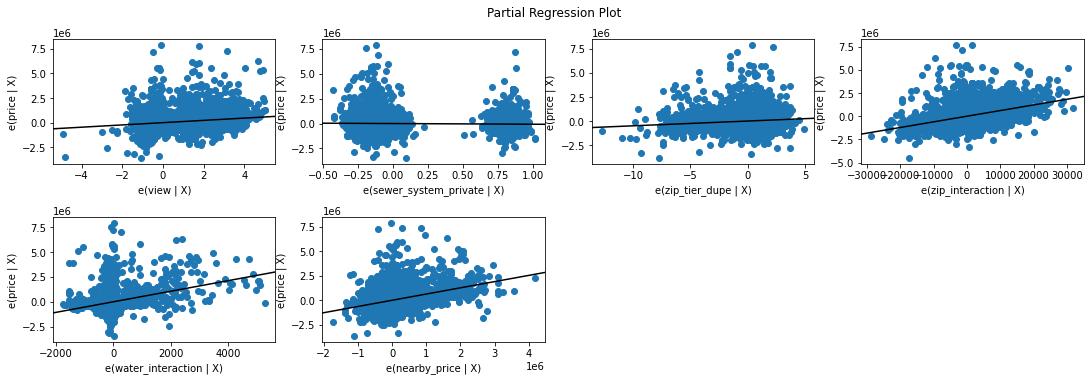

In [128]:
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(
    X_final_results,
    exog_idx=list(X_final.columns.values),
    grid=(6,4),
    fig=fig)
plt.show()

We were hoping for these plots to appear rather linear. Unfortunately they don't appear very linear.

Let's look at the Q-Q plot of residuals

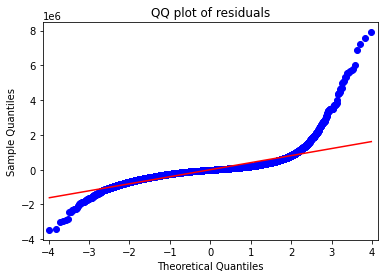

In [129]:
residuals = X_final_results.resid
sm.qqplot(residuals, line="s")
plt.title("QQ plot of residuals")
plt.show()

Here we see that the residuals are rather normal for +/- 2 standard deviations.

# Recommendations

In calculating appraisals, we recommend two key parts of the formula to follow:

1. Starting from a baseline of \\$806,800, add (or subtract) 64 cents for every \\$1 that the median home value (nearest 20-30 recent listings) exceeds (or falls short of) \\$1 million.
2. Starting from a baseline of \\$806,800, add (or subtract) \\$60 per zip code level for every square foot that the home’s living area exceeds (or falls short of) 2,000 square feet.

# Conclusion
The final model seems to do the best job possible (R^2 = 73%) without significantly cutting out more outliers or risking overfitting the model.

The error averages (RMSE above \\$400k, MAE above \\$225k) are not very reassuring.

As is often the case, the model performs best closer to its mean values, and perhaps further exploration could yield a more fruitful model based on a more limited subset of the data.